In [1]:
import os
import pandas as pd

In [3]:
manh_tiles = pd.read_csv('../data/imagery/tiles/Manhattan_256_info.csv', index_col=0)
brooklyn_tiles = pd.read_csv('../data/imagery/tiles/Brooklyn_256_info.csv', index_col=0)
print(f'Manhattan: {manh_tiles.shape}')
print(f'Brookyln: {brooklyn_tiles.shape}')

Manhattan: (80340, 8)
Brookyln: (118664, 8)


In [4]:
import sys

sys.path.append(os.path.abspath("../src"))
from intersection import Intersections


In [5]:
inter = Intersections.from_place("Downtown Brooklyn, New York, USA")
inter.with_options(tolerance=20)

nodes = inter.nodes
edges = inter.edges



INFO: Converting intersection graph to GeoDataFrames...
INFO: Consolidating intersections...
INFO: Done consolidating intersections.
INFO: Done.


In [7]:

brooklyn_tiles['topleft_x'] < brooklyn_tiles['bottomright_x'] # minx == brooklyn_tiles['topleft_x'], maxx = brooklyn_tiles['bottomright_x']
brooklyn_tiles['topleft_y'] > brooklyn_tiles['bottomright_y'] # miny == brooklyn_tiles['bottomright_x'], maxy = brooklyn_tiles['topleft_y']


import shapely
import geopandas as gpd

brooklyn_tiles_gdf = gpd.GeoDataFrame(
    brooklyn_tiles,
    crs='4326',
    geometry=brooklyn_tiles.apply(
        lambda x:
        shapely.geometry.box(x['topleft_x'], x['bottomright_y'], x['bottomright_x'], x['topleft_y']),
        axis=1
    )
)
#nodes.sjoinbrooklyn_tiles_gdf.explore()

In [8]:
BUFFER_WIDTH = 30
nodes_buffered = nodes.copy()
nodes_buffered.geometry = nodes.buffer(BUFFER_WIDTH)
nodes_buffered_joined = nodes_buffered.sjoin(brooklyn_tiles_gdf.to_crs(nodes.crs))
itx2tile = nodes_buffered_joined.reset_index().rename(columns={'osmid':'itx_id'})[['itx_id','index_right']].value_counts().reset_index().drop(columns='count').rename(columns={'index_right':'tile_id'})

itx2tile


,itx_id,tile_id
0,0,id39038
1,48,id36488
2,44,id36488
3,45,id37220
4,45,id37221
...,...,...
218,24,id36493
219,24,id36494
220,25,id36130
221,25,id36131


In [9]:
itx2tile2 = nodes_buffered_joined.reset_index().rename(columns={'osmid':'itx_id'})[['itx_id','xtile','ytile']].value_counts().reset_index().drop(columns='count').rename(columns={'index_right':'tile_id'})
itx2tile2 = itx2tile2.set_index('itx_id')

In [14]:
#nodes.merge(itx2tile2, left_index=True, right_index=True)
import numpy as np
from PIL import Image

STATIC_PATH = '../data/imagery/tiles/static/nyc/256_19'
itx2tile2['file_path'] = itx2tile2.apply(lambda x: os.path.join(STATIC_PATH, f"{x['xtile']}_{x['ytile']}.png"), axis=1)

#.groupby(level=0).apply(list)
#itx_id2static_id

itx2tile2.groupby(level=0).count()['file_path'].sort_values(ascending=False) # ok, max = 4


# LOGIC FOR ONE INTERSECTION
example_itx = itx2tile2.loc[0].copy()
example_itx['xtile_norm'] = example_itx['xtile'] - example_itx['xtile'].min()
example_itx['ytile_norm'] = example_itx['ytile'] - example_itx['ytile'].min()

example_itx.sort_values(['xtile','ytile'])

rows = []
for y in example_itx['ytile'].unique():
    temp = example_itx[example_itx['ytile'] == y].copy()
    imgs = []
    for i in temp.sort_values('xtile')['file_path']:
        img = np.array(Image.open(i))

        imgs.append(img)
    
    row = np.hstack(imgs)
    rows.append(row)

final_plot = np.vstack(rows)


In [15]:
itx2tile2['ytile'].drop_duplicates().sort_values()

itx_id
40    197153
40    197154
63    197155
10    197156
49    197157
47    197158
48    197159
46    197160
0     197161
51    197162
45    197163
45    197164
50    197165
36    197166
35    197167
35    197168
38    197169
38    197170
66    197171
66    197172
Name: ytile, dtype: int64

In [16]:
def _stitch_image(itx_df, show=False):
    rows=[]

    for y in itx_df['ytile'].drop_duplicates().sort_values():
        temp = itx_df[itx_df['ytile'] == y].copy()
        imgs = []
        for i in temp.sort_values('xtile')['file_path']:
            img = np.array(Image.open(i))

            imgs.append(img)
        
        row = np.hstack(imgs)
        rows.append(row)

    # Stack back together
    final_image = np.vstack(rows)
    
    if show:
        plt.imshow(final_image)

    return final_image

In [17]:
images_final = []
#itx2tile2.groupby(level=0).apply(_stitch_image)
for i in itx2tile2.index.unique():
    try:
        im = _stitch_image(itx2tile2.loc[i])
        images_final.append(im)
    except Exception as e:
        print(f'{i}: {e}')

51: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 512 and the array at index 1 has size 256
40: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 256 and the array at index 1 has size 512
41: 'numpy.int64' object has no attribute 'drop_duplicates'
63: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 256 and the array at index 1 has size 512
62: 'numpy.int64' object has no attribute 'drop_duplicates'
67: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 512 and the array at index 1 has size 256
9: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 256

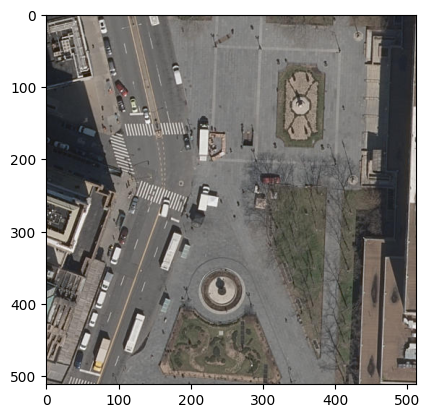

In [19]:
import matplotlib.pyplot as plt
plt.imshow(images_final[15])

In [ ]:
from PIL import Image

STATIC_PATH = 'data/imagery/tiles/static/nyc/256_19'

import matplotlib.pyplot as plt
image = plt.imread('images/my_image4.jpg')
plt.imshow(image)

for i in itx_id2static_id[0]:
    path = os.path.join(STATIC_PATH, i)
    image = Image.open(path)
    image.show()

    

In [ ]:
STITCHED_PATH = 'data/imagery/tiles/stitched/256_19_2'

files = os.listdir(STATIC_PATH)

# import matplotlib.pyplot as plt
img0 = plt.imread(os.path.join(STATIC_PATH, files[1]))
# img0.shape
files

In [ ]:
import geopandas as gpd
bk_tiles_shp = gpd.read_file('data/imagery/tiles/Brooklyn_512_pseudo_tiles')
bk_tiles_shp

In [ ]:
bk_tiles_shp['xtile'].value_counts()
bk_tiles_shp['ytile'].value_counts() # so its 326 by 364 

# now lets check if they're contiguous and in order
bk_tiles_shp['xtile'].value_counts().index.max() - bk_tiles_shp['xtile'].value_counts().index.min()
bk_tiles_shp['ytile'].value_counts().index.max() - bk_tiles_shp['ytile'].value_counts().index.min() 

# it seems like it! So: we can assign an id of xtile - min(xtile) and ytile - min(ytile)

#bk_tiles_shp[['xtile','ytile']]
bk_tiles_shp['xtile_norm'] = bk_tiles_shp['xtile'] - bk_tiles_shp['xtile'].min()
bk_tiles_shp['ytile_norm'] = bk_tiles_shp['ytile'] - bk_tiles_shp['ytile'].min()

bk_tiles_shp[['xtile_norm','ytile_norm']]

In [ ]:
# Function to stitch together 4 images

#plt.imread(os.path.join(STATIC_PATH, files[0]))
# def stitch_images(images) -> Image:
#     # Check if images are contiguous

#     # 

#     # normalize tile_ids
#     np.hstack(())

# files_sorted = sorted(files)
img0 = Image.open(os.path.join(STATIC_PATH, files[0]))
img1 = Image.open(os.path.join(STATIC_PATH, files[1]))
img2 = Image.open(os.path.join(STATIC_PATH, files[2]))
img3 = Image.open(os.path.join(STATIC_PATH, files[3]))

import numpy as np
stack0 = np.hstack([np.array(img0), np.array(img1)])
stack1 = np.hstack([np.array(img2), np.array(img3)])
np.vstack([stack0, stack0])


In [ ]:
nodes_buffered